In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import pickle

# Environment settings
data_path = 'Data/'

# load and serialize dataframes for later use in preprocessing notebook
train = pd.read_csv(data_path+'train.csv')
test = pd.read_csv(data_path+'test.csv')

print("Train set has shape {}.\nTest set has shape {} .\nCombining data..." .format(train.shape,test.shape) )

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print("Train and test set combined: {}".format(all_data.shape))

Train set has shape (1460, 81).
Test set has shape (1459, 80) .
Combining data...
Train and test set combined: (2919, 79)


# 1.Numeric features

In [164]:
numeric_features = all_data.select_dtypes(include=[np.number])
print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 36 numeric features (45.57% of total) 


## 1.1 Missing numeric values

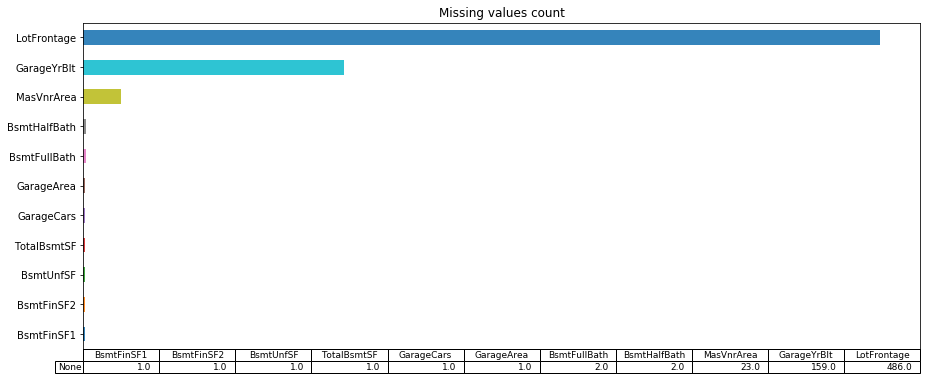

In [165]:
# Missing values# 
# number of rows
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
# fields with missing value count
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

There are 11 numerical features with missing values:
<ul>
<li>LotFrontage = Linear feet of street connected to property</li>
<li>MasVnrArea = Masonry veneer (trad.: impiallacciatura in muratura) area in square feet </li>
<li>GarageYrBlt = Year garage was built</li>
<li>GarageArea = Area of the garage </li>
<li>GarageCars = Area of garage in car capacity </li>
<li>BsmtHalfBath = Basement half bathrooms </li>
<li>BsmtFullBath = Basement full bathrooms </li>
<li>TotalBsmtSF = Total square feet of basement area </li>
<li>BsmtUnfSF =  Unfinished square feet of basement area </li>
<li>BsmtFinSF1 =  Type 1 finished square feet</li>
<li>BsmtFinSF2 =  Type 2 finished square feet</li>
</ul>

## LotFrontage
Since there a many missing values of LotFrontage we cannot simply drop those rows : the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median <b>LotFrontage</b> of the neighborhood.

In [166]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

## GarageYrBlt ,GarageArea , GarageCars

In [167]:
#Selecting only GarageType and GarageYrBlt columns
garage_year_filter=all_data[['GarageType','GarageYrBlt']]
#Checking how many missing values of GarageYrBlt correspond to GarageType NaN value
garage_year_filter =garage_year_filter[garage_year_filter['GarageType'].isna() & 
                                       garage_year_filter['GarageYrBlt'].isna()]

#Selecting only GarageType and GarageCars columns
garage_cars_filter =all_data[['GarageType','GarageCars']]
#Checking how many missing values of GarageCars correspond to GarageType NaN value
garage_cars_filter = garage_cars_filter[garage_cars_filter['GarageType'].isna() & 
                                       garage_cars_filter['GarageCars'].isna()]

#Selecting only GarageType and GarageArea columns
garage_area_filter =all_data[['GarageType','GarageArea']]
#Checking how many missing values of GarageArea correspond to GarageType NaN value
garage_area_filter = garage_area_filter[garage_area_filter['GarageType'].isna() & 
                                       garage_area_filter['GarageArea'].isna()]

print("If a house has'GarageYrBlt' NaN then it has no garage in {:.2f}% of the cases"
      .format((garage_year_filter.shape[0]/numeric_nan_length[-2])*100))
print("If a house has'GarageCars' NaN then it has no garage in {:.2f}% of the cases"
      .format((garage_cars_filter.shape[0]/numeric_nan_length[-7])*100))
print("If a house has'GarageArea' NaN then it has no garage in {:.2f}% of the cases"
      .format((garage_area_filter.shape[0]/numeric_nan_length[-6])*100))

If a house has'GarageYrBlt' NaN then it has no garage in 98.74% of the cases
If a house has'GarageCars' NaN then it has no garage in 0.00% of the cases
If a house has'GarageArea' NaN then it has no garage in 0.00% of the cases


Missing values of <b>GarageYrBlt</b> are present ~99% of the time only if that specific house doesn't have a garage.
As a specific value ( <b>'NA</b> ) is available for a good solution would be to substitute NaNs in GaragaType to NA and the corresponding GarageYrBlt to 0.0.<br><br>The remaning 2% of the houses do have a garage but have not defined values for the garage year built.Also missing values of <b>GarageCars</b> and <b>GarageArea</b> are present altough the garage type is defined (means the garage exists).<br>

In [168]:
corr = numeric_features.corr()
print (corr['GarageYrBlt'].sort_values(ascending=False)[1:4], '\n')
print (corr['GarageCars'].sort_values(ascending=False)[1:4], '\n')
print (corr['GarageArea'].sort_values(ascending=False)[1:4], '\n')

YearBuilt       0.834812
YearRemodAdd    0.652365
GarageCars      0.587712
Name: GarageYrBlt, dtype: float64 

GarageArea     0.889700
OverallQual    0.600744
GarageYrBlt    0.587712
Name: GarageCars, dtype: float64 

GarageCars     0.889700
OverallQual    0.565122
GarageYrBlt    0.555836
Name: GarageArea, dtype: float64 



Since there is a strong positive correlation between GarageYrBlt and YearBuilt a good replacement for missing values could be to use the value of the year the house was built. No such thing can be said about GarageArea and GarageCars ( they are not surprisingly highly related)

In [169]:
#Fill in 0 in all GarageYrs that don't have a Garage
all_data.loc[all_data.GarageYrBlt.isna() & 
              all_data.GarageType.isna(),
              'GarageYrBlt']=0

#Fill in with YearBuilt all those who have a garage
fill_in_values=all_data.loc[all_data.GarageYrBlt.isna(),'YearBuilt']
all_data.loc[all_data.GarageYrBlt.isna(),'GarageYrBlt'] = fill_in_values

#Set GarageCars,GarageArea NaNs to 0
all_data['GarageCars']=all_data['GarageCars'].fillna(0)
all_data['GarageArea']=all_data['GarageArea'].fillna(0)

## MasVnrArea

In [170]:
veneer_filter=all_data[['MasVnrType','MasVnrArea']]
veneer_filter = veneer_filter[veneer_filter['MasVnrArea'].isna() & veneer_filter['MasVnrType'].isna()]
print("If a house doesn't have a masonry veneer type available then it's 'MasVnrTryp' is NaN in {}% of the cases"
      .format((veneer_filter.shape[0]/numeric_nan_length[-3])*100))


If a house doesn't have a masonry veneer type available then it's 'MasVnrTryp' is NaN in 100.0% of the cases


Missing values of <b>MasVnrArea</b> are present only if that specific house doesn't have a masonry veneer type data available.<br>As a specific value ( <b>'None</b> ) is available for a good solution would be to substitute NaNs in MasVnrType to None and the corresponding MasVnrArea to 0.0.

In [171]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

## BsmtFullBath, BsmtHalfBath, TotalBsmtSF,  BsmtUnfSF, BsmtFinSF1, BsmtFinSF2
No assumptions can be made here so the best solution is to fill NaNs with zero.

In [172]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

## Checking 

In [173]:
numeric_features = all_data.select_dtypes(include=[np.number])
missing_numeric = len(numeric_features.isna().sum().where(lambda x : x > 0).dropna())
print("There are {} missing numeric values left".format(missing_numeric) )

There are 0 missing numeric values left


# 1.2 Numerical Feature Analysis

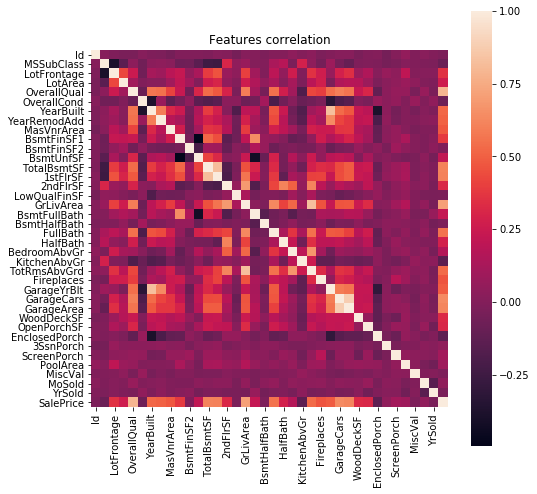

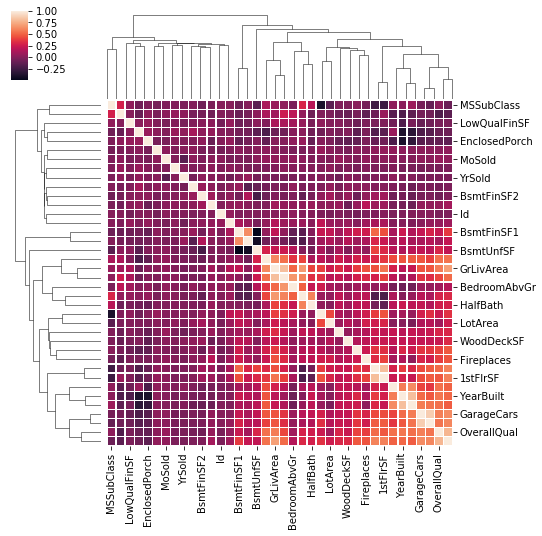

In [204]:
corrmat = train.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, square=True, annot=False) \
.set_title('Features correlation');

sns.clustermap(corrmat, square=True, annot=False,
               linewidths=.25, figsize=(8, 8))

In [175]:
#Printing highest correlation values of SalePrice
corr = train.corr()
print (corr['SalePrice'].sort_values(ascending=False)[1:4], '\n')

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
Name: SalePrice, dtype: float64 



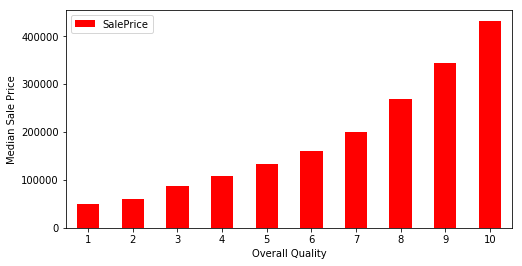

In [185]:
pivot_table =train.pivot_table(index='OverallQual',
                  values='SalePrice', 
                  aggfunc=np.median)
pivot_table\
.plot(kind='bar', color='red' , figsize=(8,4))

plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

The median sales price strictly increases as Overall Quality increases.

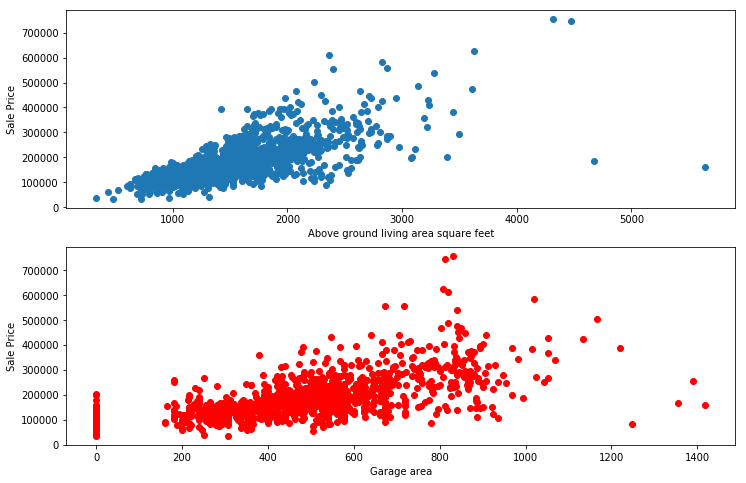

In [196]:
plt.figure(figsize=(12,8))
plt.subplot2grid((2,1), (0,0))
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above ground living area square feet')
plt.subplot2grid((2,1), (1,0))
plt.scatter(x=train['GarageArea'], y=train['SalePrice'],c='Red')
plt.ylabel('Sale Price')
plt.xlabel('Garage area')
plt.show()


# 2. Categorical data

In [197]:
cat_features = all_data.select_dtypes(exclude=[np.number])
print("There are {} categorical features ({:.2f}% of total) ".format(cat_features.shape[1],
                                                                 (cat_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 43 categorical features (54.43% of total) 


## 2.1 Missing values

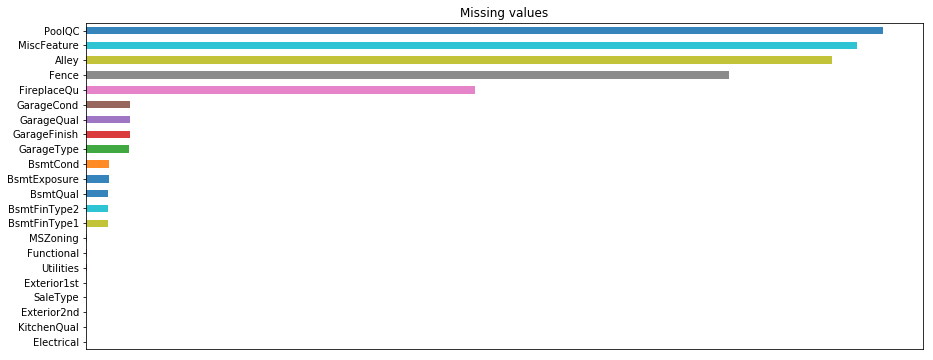

In [198]:
# number of rows
plt.figure(figsize=(15,6))
rows_length = cat_features.shape[0]
# fields with missing value count
cat_nan_length = cat_features.isna().sum().where(lambda x : x > 0).dropna()
cat_nan_length = cat_nan_length.sort_values()
ax = cat_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values')
ax.xaxis.set_visible(False) # hide x axis labels

## Non existing values
By reading the description.txt file most NaN's correspond to non existing feature. These can be replace with 'None'.

In [199]:
none_colums=["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageCond","GarageFinish","Functional",
            "GarageQual","GarageType","BsmtCond","BsmtExposure","BsmtQual","BsmtFinType2","BsmtFinType1",
             "MasVnrType"]
for col in none_colums:
    all_data[col] = all_data[col].fillna('None')

## MSZoning
Identifies the general zoning classification of the sale. This value can be deduced by taking the mode of the neighbourhood.

In [200]:
all_data["MSZoning"] = all_data.groupby("Neighborhood")["MSZoning"].transform(lambda x: x.fillna(x.mode()))
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

## Utilities
Utilities has all records are "AllPub", except for one "NoSeWa" and 2 missing values. Since the house with 'NoSewa' is in the training set, this feature won't help to predict labels in the test set. We can then safely remove it

In [201]:
all_data = all_data.drop(['Utilities'], axis=1)

# Filling missing with mode
Some features have missing values which can be replaced by the mode of the feature if no further assumptions can be made.

In [202]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# Checking

In [203]:
cat_features = all_data.select_dtypes(exclude=[np.number])
missing_cat = len(cat_features.isna().sum().where(lambda x : x > 0).dropna())
print("There are {} missing numeric values left".format(missing_cat) )

There are 0 missing numeric values left


## 2.2 One Hot Encoding

In [ ]:
all_data = pd.get_dummies(all_data)

# 3. Save new data

In [206]:
train_clean= all_data[:train.shape[0]].copy()
train_clean['SalePrice'] = train.SalePrice
test_clean = all_data[train.shape[0]:]

# Serialize dataframes for later use in implementations
with open(data_path+'train_pp.obj', 'wb') as file:
        pickle.dump(train_clean, file)
with open(data_path+'test_pp.obj', 'wb') as file:
        pickle.dump(test_clean, file)